<a href="https://colab.research.google.com/github/peeyushsinghal/ERA/blob/main/ERA/ERA_S7_13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objective / Target
**Objective / Target**
* Increase accuracy by increasing capacity
* Play with LR

**Results**

* Parameters: 7,900
* Best Train Accuracy: 98.94
* Best Test Accuracy: 99.25

**Analysis**

* Not Able to hit the accuracy mark
* Overfitting (train - test accuracy) < 0 is largely containted, model underfits (Target not achieved)
* LR has played its role to move up the accuracy
* Number of params < 8K
* Removing param near output does not help much,

**Next Steps**

* Remove params from near input, add near output
* play with LR


# Importing Libraries

In [48]:
import torch
from torchvision import datasets,transforms
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt # for visualizing images
import random # for random image index
import torch.nn as nn # for network
import torch.nn.functional as F # for forward method
import torch.optim as optim # for optimizer
!pip install torchsummary
from torchsummary import summary # for model summary and params
from tqdm import tqdm # for beautiful model training updates

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Seed and Cuda

In [49]:
# check for cuda
cuda = torch.cuda.is_available()
print (f' Cuda Status : {cuda}')

# setting seed
SEED = 42 # arbit seed, why 42 - because in hitch hikers guide to galaxy it is answer to everything
# torch.cuda.seed(SEED)
torch.cuda.manual_seed_all(SEED) if cuda else torch.manual_seed(SEED)

 Cuda Status : True


# Data Transformations

In [50]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(), # converts to tesnor
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),# converts to tesnor
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train / Test Split

In [51]:
train = datasets.MNIST('./data', # directory where data needs to be stored
                       train=True, # get the training portion of the dataset
                       download=True, # downloads
                       transform=train_transforms)
test = datasets.MNIST('./data',
                      train=False,
                      download=True,
                      transform=test_transforms)

## Data Loader

In [52]:
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory = True) if cuda else dict(shuffle=True, batch_size=64)

train_loader = torch.utils.data.DataLoader(
    dataset=train,# train dataset
    **dataloader_args # the dataloader arguments change dependent on cuda is available or not
    )

test_loader = torch.utils.data.DataLoader(
    dataset = test,# test dataset
    **dataloader_args # the dataloader arguments change dependent on cuda is available or not
)

## Checking Dataloader

torch.Size([128, 1, 28, 28])
torch.Size([128])


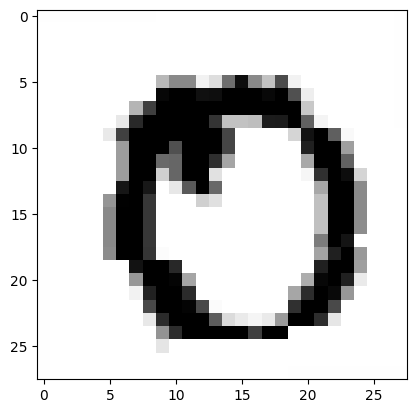

In [53]:
images, labels  = next(iter(train_loader))
print(images.shape)
print(labels.shape)
# printing random image and seeing
plt.imshow(images[random.randint(0,len(images))].numpy().squeeze(), cmap='gray_r')

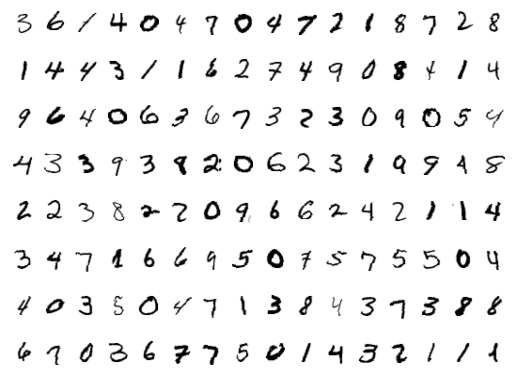

In [54]:
# Looking at more images
figure = plt.figure()
for index in range(1, len(images) + 1): # assumption: batch size would be atleast 8
    plt.subplot(8, int(len(images)/8), index)
    plt.axis('off')
    plt.imshow(images[index-1].numpy().squeeze(), cmap='gray_r')

# Model

In [61]:
class Network(nn.Module):
  def __init__(self):
    super(Network,self).__init__() # extending super class method

    drop_out_value = 0.1

    # Input Block
    self.convblock1 = nn.Sequential(
        nn.Conv2d(1,8,3 , bias= False ), # In- 1x28x28, Out- 16x26x26, RF- 3x3, Jump_in -1, Jump_out -1
        nn.ReLU(),
        nn.BatchNorm2d(8),# affine=False),
        nn.Dropout(drop_out_value)
    )

    # Conv Block 2
    self.convblock2 = nn.Sequential(
        nn.Conv2d(8,16,3, bias= False ), # In- 16x26x26, Out- 16x24x24, RF- 5x5, Jump_in -1, Jump_out -1
        nn.ReLU(),
        nn.BatchNorm2d(16),# affine=False),
        nn.Dropout(drop_out_value)
    )

    # Conv Block 3
    self.convblock3 = nn.Sequential(
        nn.Conv2d(16,16,3, bias= False ), # In- 16x24x24, Out- 16x22x22, RF- 7x7, Jump_in -1, Jump_out -1
        nn.ReLU(),
        nn.BatchNorm2d(16),# affine=False),
        nn.Dropout(drop_out_value)
    )

    # Transition Block 1 (this also includes a conv block)
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # In- 16x22x22, Out- 16x11x11, RF- 8x8, Jump_in -1, Jump_out -2
    # self.convblock4 = nn.Sequential(
    #     nn.Conv2d(32,16,1), # In- 32x12x12, Out- 16x12x12, RF- 8x8, Jump_in -2, Jump_out -2
    #     nn.ReLU(),
    #     nn.BatchNorm2d(16),
    #     nn.Dropout(drop_out_value)
    # )

    # Conv Block 5
    self.convblock5 = nn.Sequential(
        nn.Conv2d(16,16,3, bias= False ), # In- 16x11x11, Out- 16x9x9, RF- 12x12, Jump_in -2, Jump_out -2
        nn.ReLU(),
        nn.BatchNorm2d(16),# affine=False),
        nn.Dropout(drop_out_value)
    )

    # Conv Block 6
    self.convblock6 = nn.Sequential(
        nn.Conv2d(16,16,3, bias= False ), # In- 16x9x9, Out- 16x7x7, RF- 16x16, Jump_in -2, Jump_out -2
        nn.ReLU(),
        nn.BatchNorm2d(16),# affine=False),
        nn.Dropout(drop_out_value)
    )

    # Output Block
    self.convblock7 = nn.Sequential(
        nn.Conv2d(16,10,1, bias= False ), # In- 16x7x7, Out- 10x7x7, RF- 16x16, Jump_in -2, Jump_out -2
        # nn.ReLU()
        # ,
        # nn.BatchNorm2d(10, affine=True),
        # nn.Dropout(drop_out_value)
    )

    self.gap = nn.AvgPool2d(7) # In- 10x7x7, Out- 10x1x1, RF- 16x16, Jump_in -2, Jump_out -2


  def forward(self,x):

    x = self.convblock1(x)
    x = self.convblock2(x)
    x = self.convblock3(x)

    x = self.pool1(x)
    # x = self.convblock4(x)
    x = self.convblock5(x)
    x = self.convblock6(x)

    x = self.convblock7(x)

    x = self.gap(x)

    # Flattening
    x = x.view(-1,10)
    return F.log_softmax(x,dim=-1)

# model = Network()
# print(model)

## Model Params

In [62]:
device = torch.device("cuda" if cuda else "cpu")
print(device)
model = Network().to(device)
# print(model)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 26, 26]             108
              ReLU-2           [-1, 12, 26, 26]               0
       BatchNorm2d-3           [-1, 12, 26, 26]              24
           Dropout-4           [-1, 12, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,728
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9           [-1, 12, 22, 22]           1,728
             ReLU-10           [-1, 12, 22, 22]               0
      BatchNorm2d-11           [-1, 12, 22, 22]              24
          Dropout-12           [-1, 12, 22, 22]               0
        MaxPool2d-13           [-1, 12, 11, 11]               0
           Conv2d-14             [

# Training and Testing

## Training

In [63]:
# Training Function
train_losses = [] # to capture train losses over training epochs
train_accuracy = [] # to capture train accuracy over training epochs

def train(model,device, train_loader,optimizer,epoch):
  model.train() # setting the model in training mode
  pbar = tqdm(train_loader) # putting the iterator in pbar
  correct = 0 # for accuracy numerator
  processed =0 # for accuracy denominator

  for batch_idx, (images,labels) in enumerate(pbar):
    images, labels = images.to(device),labels.to(device)#sending data to CPU or GPU as per device
    optimizer.zero_grad() # setting gradients to zero to avoid accumulation

    y_preds = model(images) # forward pass, result captured in y_preds (plural as there are many images in a batch)
    # the predictions are in one hot vector

    loss = F.nll_loss(y_preds,labels) # capturing loss
    train_losses.append(loss) # to capture loss over many epochs

    loss.backward() # backpropagation
    optimizer.step() # updating the params

    preds = y_preds.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += preds.eq(labels.view_as(preds)).sum().item()
    processed += len(images)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}%')
    train_accuracy.append(100*correct/processed)


## Test

In [64]:
# Test Function
test_losses = [] # to capture test losses
test_accuracy = [] # to capture test accuracy

def test(model,device, test_loader):
  model.eval() # setting the model in evaluation mode
  test_loss = 0
  avg_epoch_test_loss =[]
  correct = 0 # for accuracy numerator

  with torch.no_grad():
    for (images,labels) in test_loader:
      images, labels = images.to(device),labels.to(device)#sending data to CPU or GPU as per device
      outputs = model(images) # forward pass, result captured in outputs (plural as there are many images in a batch)
      # the outputs are in batch size x one hot vector

      test_loss = F.nll_loss(outputs,labels, reduction='sum').item()  # sum up batch loss
      preds = outputs.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += preds.eq(labels.view_as(preds)).sum().item()

    test_loss /= len(test_loader.dataset) # average test loss
    test_losses.append(test_loss) # to capture loss over many batches
    avg_epoch_test_loss.append(test_loss)

    print('\nTest set: Average loss: {:.6f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

    test_accuracy.append(100*correct/len(test_loader.dataset))
  return float("{:.4f}".format(np.average(avg_epoch_test_loss)))


## Execution

In [65]:

## Weight initialization

def weights_init(m):
    if isinstance(m, nn.Conv1d):
      nn.init.xavier_normal_(m.weight)


In [66]:
model =  Network().to(device)
model.apply(weights_init)
optimizer = optim.SGD(model.parameters(), lr=0.3, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr=0.3)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)
# LR_GAMMA = 0.5
from torch.optim.lr_scheduler import StepLR,ReduceLROnPlateau,ExponentialLR
# scheduler = StepLR(optimizer, step_size=4, gamma=0.1)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 2, threshold =  0.0002, verbose = True)
# scheduler = ExponentialLR (optimizer, gamma =0.3)


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1 , "Current LR : ", optimizer.param_groups[0]['lr'])
    train(model, device, train_loader, optimizer, epoch)
    curr_lr = optimizer.param_groups[0]['lr']
    # print(f'current learning rate :', curr_lr)
    val_loss = test(model, device, test_loader)
    # print(f'current learning rate :{curr_lr} and val_loss is {val_loss}')
    scheduler.step(val_loss)
    # if epoch > 5:
    #   optimizer = optim.SGD(model.parameters(), lr=curr_lr*LR_GAMMA, momentum=0.9)




EPOCH: 1 Current LR :  0.3


Loss=0.08516135811805725 Batch_id=468 Accuracy=92.65%: 100%|██████████| 469/469 [00:25<00:00, 18.22it/s]



Test set: Average loss: 0.000038, Accuracy: 9783/10000 (97.83%)

EPOCH: 2 Current LR :  0.3


Loss=0.015052396804094315 Batch_id=468 Accuracy=97.39%: 100%|██████████| 469/469 [00:22<00:00, 20.79it/s]



Test set: Average loss: 0.000001, Accuracy: 9827/10000 (98.27%)

EPOCH: 3 Current LR :  0.3


Loss=0.10182078927755356 Batch_id=468 Accuracy=97.82%: 100%|██████████| 469/469 [00:22<00:00, 20.97it/s]



Test set: Average loss: 0.000341, Accuracy: 9801/10000 (98.01%)

EPOCH: 4 Current LR :  0.3


Loss=0.12199262529611588 Batch_id=468 Accuracy=98.18%: 100%|██████████| 469/469 [00:24<00:00, 19.33it/s]



Test set: Average loss: 0.000261, Accuracy: 9788/10000 (97.88%)

Epoch 00004: reducing learning rate of group 0 to 3.0000e-02.
EPOCH: 5 Current LR :  0.03


Loss=0.014966137707233429 Batch_id=468 Accuracy=98.67%: 100%|██████████| 469/469 [00:23<00:00, 19.88it/s]



Test set: Average loss: 0.000015, Accuracy: 9919/10000 (99.19%)

EPOCH: 6 Current LR :  0.03


Loss=0.06419865041971207 Batch_id=468 Accuracy=98.76%: 100%|██████████| 469/469 [00:24<00:00, 19.35it/s]



Test set: Average loss: 0.000003, Accuracy: 9916/10000 (99.16%)

EPOCH: 7 Current LR :  0.03


Loss=0.02050761692225933 Batch_id=468 Accuracy=98.79%: 100%|██████████| 469/469 [00:25<00:00, 18.10it/s]



Test set: Average loss: 0.000275, Accuracy: 9925/10000 (99.25%)

Epoch 00007: reducing learning rate of group 0 to 3.0000e-03.
EPOCH: 8 Current LR :  0.003


Loss=0.023809874430298805 Batch_id=468 Accuracy=98.89%: 100%|██████████| 469/469 [00:27<00:00, 17.37it/s]



Test set: Average loss: 0.000003, Accuracy: 9918/10000 (99.18%)

EPOCH: 9 Current LR :  0.003


Loss=0.03042856603860855 Batch_id=468 Accuracy=98.87%: 100%|██████████| 469/469 [00:25<00:00, 18.75it/s]



Test set: Average loss: 0.000003, Accuracy: 9924/10000 (99.24%)

EPOCH: 10 Current LR :  0.003


Loss=0.022277062758803368 Batch_id=468 Accuracy=98.87%: 100%|██████████| 469/469 [00:25<00:00, 18.10it/s]



Test set: Average loss: 0.000000, Accuracy: 9917/10000 (99.17%)

Epoch 00010: reducing learning rate of group 0 to 3.0000e-04.
EPOCH: 11 Current LR :  0.00030000000000000003


Loss=0.003223830135539174 Batch_id=468 Accuracy=98.84%: 100%|██████████| 469/469 [00:25<00:00, 18.29it/s]



Test set: Average loss: 0.000001, Accuracy: 9918/10000 (99.18%)

EPOCH: 12 Current LR :  0.00030000000000000003


Loss=0.05064189061522484 Batch_id=468 Accuracy=98.95%: 100%|██████████| 469/469 [00:28<00:00, 16.75it/s]



Test set: Average loss: 0.000204, Accuracy: 9925/10000 (99.25%)

EPOCH: 13 Current LR :  0.00030000000000000003


Loss=0.004032948054373264 Batch_id=468 Accuracy=98.84%: 100%|██████████| 469/469 [00:30<00:00, 15.32it/s]



Test set: Average loss: 0.000247, Accuracy: 9916/10000 (99.16%)

Epoch 00013: reducing learning rate of group 0 to 3.0000e-05.
EPOCH: 14 Current LR :  3.0000000000000004e-05


Loss=0.04666073992848396 Batch_id=468 Accuracy=98.88%: 100%|██████████| 469/469 [00:29<00:00, 15.89it/s]



Test set: Average loss: 0.000004, Accuracy: 9919/10000 (99.19%)

EPOCH: 15 Current LR :  3.0000000000000004e-05


Loss=0.0201981533318758 Batch_id=468 Accuracy=98.89%: 100%|██████████| 469/469 [00:25<00:00, 18.22it/s]



Test set: Average loss: 0.000020, Accuracy: 9918/10000 (99.18%)



Text(0.5, 1.0, 'Test Accuracy')

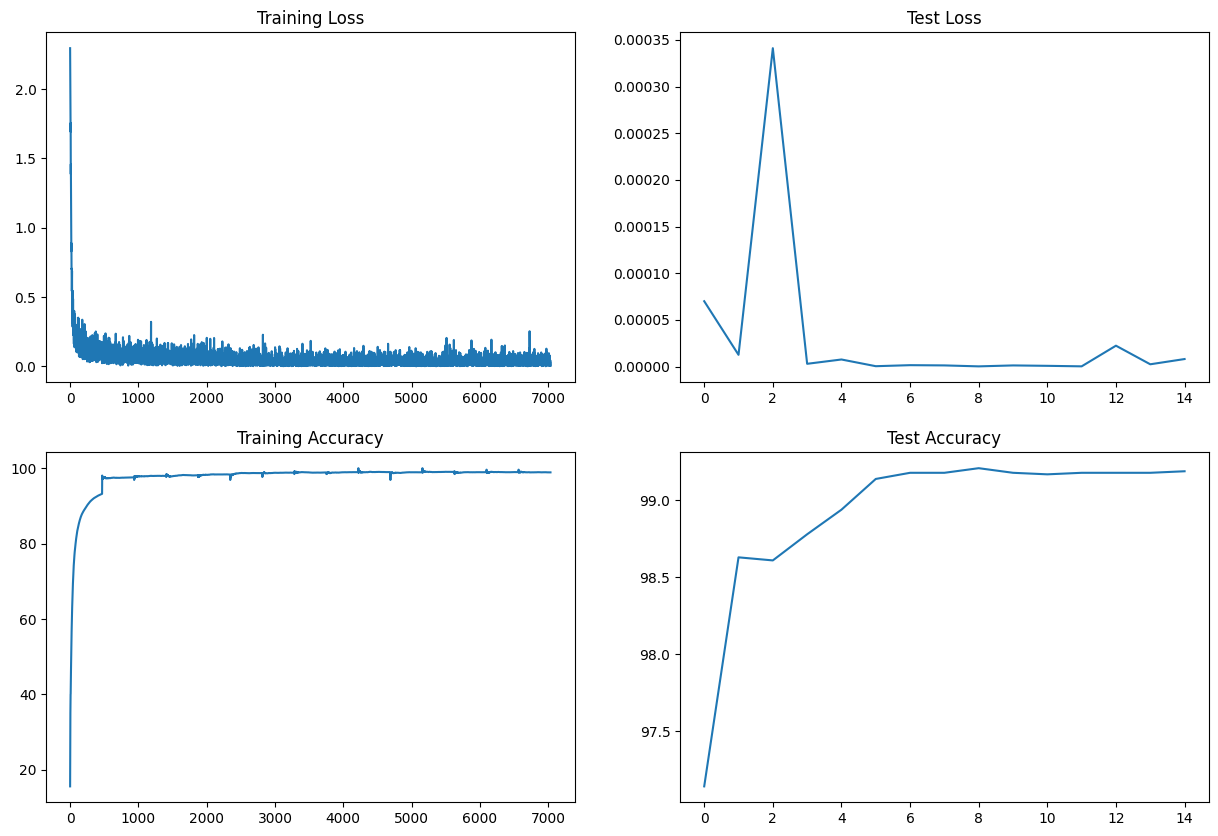

In [47]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
# axs[0, 0].plot(train_losses)
axs[0, 0].plot([t.cpu().item() for t in train_losses])
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_accuracy)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_accuracy)
axs[1, 1].set_title("Test Accuracy")